In [30]:
# Data handling
import numpy as np
import pandas as pd
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import graphviz
import optuna
import optuna.visualization as vis
%matplotlib inline

# Stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import shapiro, norm, chi2_contingency, kstest, boxcox

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

#lib
from lib.clean_data_functions import clean_ext_version, clean_ext_publisher, clean_repo_publisher

#
from wordcloud import WordCloud,STOPWORDS
from ast import literal_eval
from collections import Counter

# os
import os

# time
import time

import warnings
# warnings.filterwarnings("ignore")    # (Optional)

print("Project has been created with Pandas: " ,pd. __version__," And with Numpy: ",np. __version__)

Project has been created with Pandas:  2.3.1  And with Numpy:  2.3.2


### Loading

In [31]:
import yaml

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [32]:
df = pd.read_csv(config["data"]["clean"]["file_eda_cleaned"])
# df = df.sort_values(by = ["ext_install_count", "ext_rating"], ascending= False)
df.head()

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
0,Programming Languages,177844528,True,0,0,0,0,4461,1247,typescript,4 and above,2 and above
1,Programming Languages,177844528,True,0,0,0,0,4461,1247,python,4 and above,2 and above
2,Programming Languages,177844528,True,0,0,0,0,4461,1247,javascript,4 and above,2 and above
3,Programming Languages,177844528,True,0,0,0,0,4461,1247,jupyter notebook,4 and above,2 and above
4,Programming Languages,177844528,True,0,0,0,0,4461,1247,shell,4 and above,2 and above


### 5. Preprocessing 

In [33]:
cols_num = df.select_dtypes(include = ["int64","float64"]).columns.to_list()
cols_cat = df.select_dtypes(include = ["object","category"]).columns.to_list()

Handle duplicated

In [34]:
df.duplicated().sum()

np.int64(1174)

In [35]:
df[df.duplicated()]

,ext_categories,ext_install_count,verified,total_vulners,high_vulners,medium_vulners,low_vulners,repo_stars,repo_forks,repo_languages,ext_rating_category,ext_version_category
9883,Themes,10799,False,0,0,0,0,1,0,unknown,4 and above,0
12425,Snippets,6464,False,0,0,0,0,0,0,unknown,4 and above,0
13421,Themes,5285,False,0,0,0,0,0,0,unknown,4 and above,0
16349,Snippets,3292,False,0,0,0,0,0,0,unknown,4 and above,0
17291,Themes,2856,False,0,0,0,0,0,0,unknown,4 and above,0
...,...,...,...,...,...,...,...,...,...,...,...,...
37899,Other,9,False,0,0,0,0,0,0,typescript,0,0
37900,Other,9,False,0,0,0,0,0,0,typescript,0,0
37902,Other,9,False,0,0,0,0,1,0,typescript,0,0
37903,Other,9,False,0,0,0,0,1,0,javascript,0,0


In [36]:
# df[df[""]]

Handle missing values

In [37]:
df.isna().sum()

ext_categories          0
ext_install_count       0
verified                0
total_vulners           0
high_vulners            0
medium_vulners          0
low_vulners             0
repo_stars              0
repo_forks              0
repo_languages          0
ext_rating_category     0
ext_version_category    0
dtype: int64

### Outliers: after Univariate (according to lab). Or after Bivariate

**Outliers detection**

In [ ]:
def detect_iqr_outliers(df: pd.DataFrame, column, floor, ceiling):
    out=[]
    Q1 = df[column].quantile(floor)
    Q3 = df[column].quantile(ceiling)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for x in df[column]:
        if x > upper_bound or x < lower_bound:
            out.append(x)
    return out

# for col in cols_num:
#     print(f" Total outliers in '{col}':  {len(detect_iqr_outliers(df, col, 0.2, 0.8))} \n")

In [ ]:
def detect_winsor_outliers(df: pd.DataFrame, column, floor, ceiling):
    out=[]
    q1 = np.percentile(df , floor)
    q3 = np.percentile(df , ceiling)

    for x in df[column]:
        if x > q3 or x < q1:
            out.append(x)
    return out

for col in cols_num:
    print(f" Total outliers in '{col}':  {len(detect_winsor_outliers(df, col, 5, 95))} \n")

**Outliers handle**

- IRQ-Outliers removing -> Delete observations, not gonna use it

In [39]:
# def remove_iqr_outliers(df: pd.DataFrame, column) -> pd.DataFrame:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#     return df

- Impute Outliers using median

In [ ]:
for col in cols_num:
    med = np.median(df[col])
    outliers_imputing = detect_winsor_outliers(df, col, 5, 95)
    df.iloc[outliers_imputing.index,:][col] = med

- Transform 

-0.09485556772336341


Text(0.5, 1.0, 'Box-Cox Transformed ext_install_count')

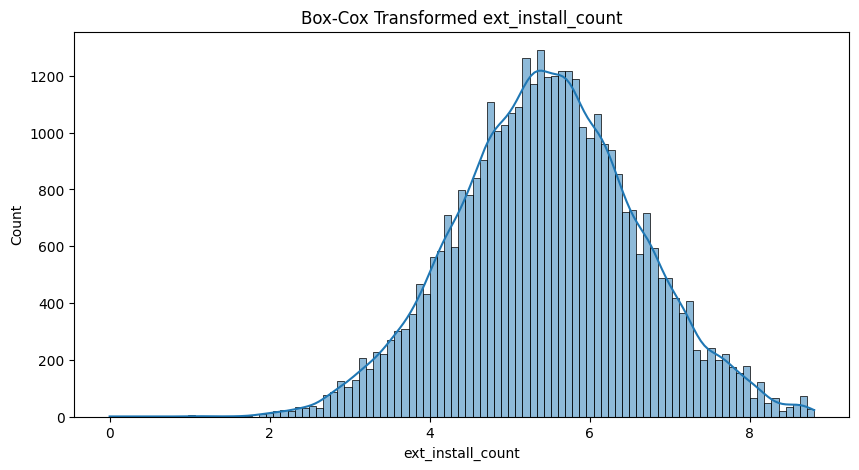

In [40]:
# Applying Box-Cox transformation to columns  with high skewness and positive values.

df["ext_install_count"], power_install_count = boxcox(df["ext_install_count"])

print(power_install_count)

# Plotting the transformed distributions
plt.figure(figsize=(10,5))

# Box-Cox transformed 'LotArea'
sns.histplot(df["ext_install_count"], kde=True)
plt.title("Box-Cox Transformed ext_install_count")



In [ ]:
# def training_classification():
#     rfc = RandomForestClassifier()
#     abc = AdaBoostClassifier()
#     gbc = GradientBoostingClassifier()
#     etc = ExtraTreesClassifier()
#     lgr = LogisticRegression()
#     svc = SVC()
#     mnb = MultinomialNB()
#     xgb = XGBClassifier()
#     lgb = LGBMClassifier(verbose=-100)
#     cat = CatBoostClassifier(verbose=False)

#     models = [rfc, abc, gbc, etc, lgr,
#              svc, mnb, xgb, lgb, cat]

#     names = ["Random Forest", "Ada Boost", "Gradient Boosting", "Extra Trees", "Logistic Regression",
#             "SVC", "Naive Bayes", "XGBoost", "LightGBM", "Cat Boost"]

#     scores = []
#     cms = dict()
#     reports = dict()

#     for i, j in enumerate(names):
#         models[i].fit(x_train, y_train)
#         pred = models[i].predict(x_test)
#         scores += [accuracy_score(pred, y_test)]
#         cms[j] = confusion_matrix(pred, y_test)
#         reports[j] = classification_report(pred, y_test)

#     dt = pd.DataFrame({"scores": scores}, index=names)
#     dt = dt.sort_values("scores", ascending=False)

#     dt["scores"] = dt["scores"]*100
#     dt["scores"] = round(dt["scores"], 2)

#     fig, axes = plt.subplots(figsize=(15, 6))

#     dt["scores"].plot(kind="bar", ax=axes)
#     bar_labels(axes)

#     index = 0

#     for _ in range(2):
#         fig, axes = plt.subplots(ncols=5, figsize=(15, 6))
#         for i in range(5):
#             sns.heatmap(cms[dt.index[index]], annot=True, ax=axes[i])
#             axes[i].set_title("{}: {}%".format(dt.index[index], dt.iloc[index, 0]))
#             index += 1
#         plt.tight_layout()
#         plt.show()

#     for i in dt.index:
#         print("*"*30)
#         print("\n")
#         print(i)
#         print("\n")
#         print(reports[i])


In [ ]:
# def plot_histograms_by_diagnosis(df, target='diagnosis', exclude_cols=None, bins=30, cols_per_row=3):
#     import matplotlib.pyplot as plt
#     import seaborn as sns

#     if exclude_cols is None:
#         exclude_cols = []

#     # Select only numerical columns except the target and excluded ones
#     num_cols = df.select_dtypes(include='number').columns.difference(exclude_cols + [target])
#     n = len(num_cols)
#     nrows = (n + cols_per_row - 1) // cols_per_row

#     fig, axes = plt.subplots(nrows, cols_per_row, figsize=(6 * cols_per_row, 4 * nrows))
#     axes = axes.flatten()

#     for i, col in enumerate(num_cols):
#         for diagnosis in df[target].unique():
#             sns.histplot(df[df[target] == diagnosis][col],
#                          label=str(diagnosis),
#                          bins=bins,
#                          kde=False,
#                          ax=axes[i],
#                          element='step',
#                          stat='density')

#         axes[i].set_title(f'{col} distribution by {target}', fontsize=10)
#         axes[i].legend(title=target)

#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

- 🌲 Random Forest

Ensemble of decision trees (bagging).
Uses random subsets of data and features.
Robust to overfitting and outliers.
Good baseline model for tabular data.
- ⚡ AdaBoost

Sequential boosting of weak learners.
Focuses on previous misclassified samples.
Sensitive to noise/outliers.
Good for clean data with subtle patterns.
- 🚀 XGBoost

Optimized gradient boosting algorithm.
Fast, accurate, and regularized.
Best for performance with tuning effort.

- 📊 Logistic Regression

Linear model for binary classification.
Estimates probabilities using a sigmoid function.
Assumes a linear relationship between features and the log-odds of the target.
Simple, fast, and interpretable — great baseline for linearly separable data.

- 🎯 Support Vector Machine (SVM)

Finds the optimal hyperplane that maximizes the margin between classes.
Works well in high-dimensional spaces.
Can use different kernels (linear, RBF, polynomial) to capture nonlinear patterns.
Sensitive to scaling; may be slower on large datasets.

- 👟 K-Nearest Neighbors (KNN)

Instance-based learning — no training, just storing.
Classifies based on the majority label among k-nearest neighbors.
Simple and intuitive, but slow with large datasets.
Sensitive to feature scaling and irrelevant features.